# CoVid-19 Pandemic Statistics

Analysis of the CoVid-19 outbreak in Italy.

Total population of some Italian regions of interest extracted from: https://www.tuttitalia.it/regioni/popolazione

An analysis by CNR (in Italian): https://www.cnr.it/it/nota-stampa/n-9281/analisi-numerica-dei-dati-relativi-alla-diffusione-del-covid-19-in-italia-e-nel-mondo

In [1]:
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Total population of some Italian regions
pop = {}
pop['Lombardia'] = 10
pop['Veneto'] = 4.9
pop['Emilia Romagna'] = 4.4
pop['Piemonte'] = 4.3
pop['Marche'] = 1.5
pop['Sicilia'] = 5
pop['Campania'] = 5.8

In [9]:
# This is the Github repo with the Italian detailed data
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv'
df = pd.read_csv(url)
df[df['denominazione_provincia'] == 'Piacenza']

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
27,2020-02-24 18:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,0
155,2020-02-25 18:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,18
283,2020-02-26 18:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,28
411,2020-02-27 18:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,63
539,2020-02-28 18:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,89
667,2020-02-29 17:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,138
795,2020-03-01 17:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,174
923,2020-03-02 17:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,212
1051,2020-03-03 17:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,256
1179,2020-03-04 17:00:00,ITA,8,Emilia Romagna,33,Piacenza,PC,45.051935,9.692633,319


In [17]:
df.describe()

,codice_regione,codice_provincia,lat,long,totale_casi
count,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000
mean,10.140625,207.523438,35.868843,10.112000,110.461227
std,5.915264,347.433297,16.073850,5.098330,378.722715
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,5.000000,32.750000,38.848542,8.583304,0.000000
50%,9.000000,64.500000,42.609815,11.188560,6.000000
75%,15.250000,96.250000,44.947714,13.593962,58.000000
max,20.000000,999.000000,46.499335,18.171897,5869.000000


In [4]:
### Some data manipulation. Refer to https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas

regdf = {}
for r in pop:
  # sum over all provinces for a given date ('data')
  # + rename data -> date, totale_casi -> region name
  regdf[r] = df[df['denominazione_regione'] == r].groupby('data')[['totale_casi']].sum() \
             .reset_index() \
             .rename(columns={'data': 'date', 'totale_casi': r})

  # convert date format to days since Feb 29th
  regdf[r]['date'] = regdf[r]['date'].map(lambda d : \
        (datetime.strptime(d, '%Y-%m-%d %H:%M:%S') - datetime.strptime('2020-02-29','%Y-%m-%d')).days)

  # convert #cases to cases per 1M inhabitants
  regdf[r][r] /= pop[r]

regdf['Lombardia']

,date,Lombardia
0,-5,0.0
1,-4,24.0
2,-3,25.8
3,-2,40.3
4,-1,53.1
5,0,61.5
6,1,98.4
7,2,125.4
8,3,152.0
9,4,182.0


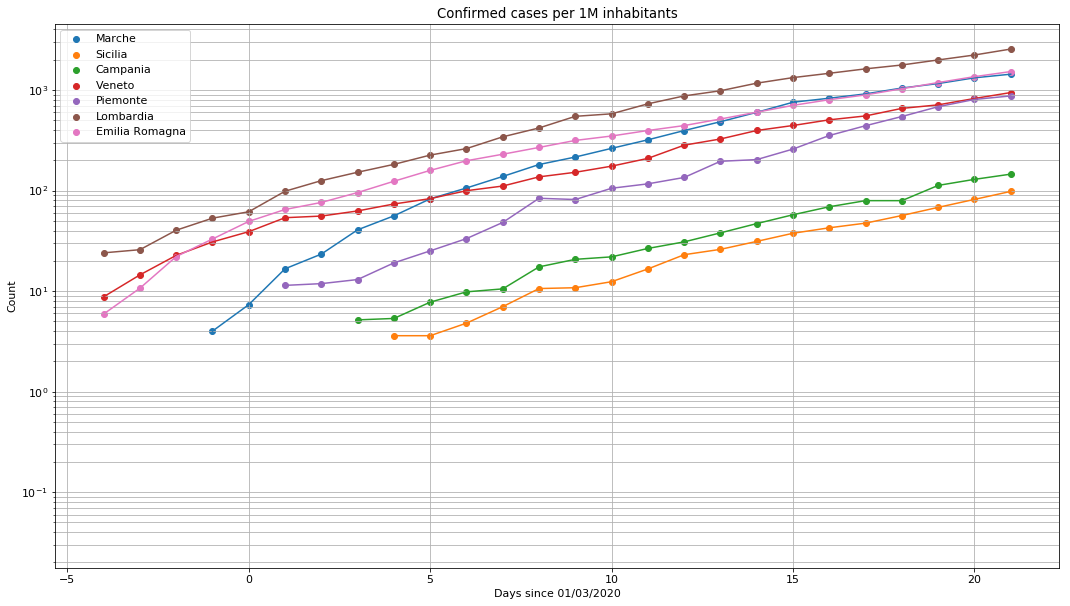

In [5]:
plt.rcParams['figure.figsize'] = [18, 10]
plt.rc('font', size=11)

for r in pop:
  # drop first days as the data is noisy: keep after value > 2 cases / 1M people
  regdf[r] = regdf[r][regdf[r].gt(3).any(axis=1)]

  # get all data points
  t = list(regdf[r].iloc[:, 0]) 
  y = list(regdf[r].iloc[:, 1])
  plt.scatter(t, y, label=r)   # draw the dots
  plt.plot(t, y)   # draw the lines

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since 01/03/2020")
plt.ylabel("Count")
plt.yscale('log')
plt.grid(which='both')
plt.show()

# Models and curves fitting

Now let's create the two curves and fit the data to both (cf. Europe notebook):
* The exponential fit
* The "logistic" fit

In [6]:
def exp_model(t, a, b, c):
  return a*np.exp((t-b)/c)

def logistic_model(t, a, b, c):
  return a/(1+np.exp(-(t-b)/c))

In [7]:
logit_fit = {}
exp_fit = {}
for r in pop:
  t = list(regdf[r].iloc[:,0])
  y = list(regdf[r].iloc[:,1])
  try:
    exp_fit[r] = curve_fit(exp_model, t, y, p0=[0.01, 0.5, 3])
  except RuntimeError:
    exp_fit[r] = None
    pass
  try:
    logit_fit[r] = curve_fit(logistic_model, t, y, p0=[100000, 40, 3])
  except RuntimeError:
    logit_fit[r] = None
logit_fit

{'Campania': (array([621.53622396,  27.08826278,   5.18425032]),
  array([[1.36369626e+05, 1.63994003e+03, 1.57828482e+02],
         [1.63994003e+03, 1.97935636e+01, 1.93576248e+00],
         [1.57828482e+02, 1.93576248e+00, 2.04614633e-01]])),
 'Emilia Romagna': (array([5277.63535591,   26.57615161,    6.1368432 ]),
  array([[1.12500767e+06, 1.97855877e+03, 2.24163870e+02],
         [1.97855877e+03, 3.49565012e+00, 4.03355417e-01],
         [2.24163870e+02, 4.03355417e-01, 5.07054219e-02]])),
 'Lombardia': (array([4105.09781939,   18.99422959,    5.07336508]),
  array([[1.03031902e+05, 2.54013009e+02, 6.25122988e+01],
         [2.54013009e+02, 6.33215820e-01, 1.58392602e-01],
         [6.25122988e+01, 1.58392602e-01, 4.51925807e-02]])),
 'Marche': (array([1995.58560626,   17.44995387,    3.97032012]),
  array([[8.11055594e+03, 3.55312269e+01, 1.11588354e+01],
         [3.55312269e+01, 1.58882106e-01, 5.01492507e-02],
         [1.11588354e+01, 5.01492507e-02, 1.89694012e-02]])),
 'Piem

In [8]:
tdoubling = {}
for r in pop:
  tdoubling[r] = int(10*exp_fit[r][0][2]*np.log(2))/10.0
tdoubling

{'Campania': 4.0,
 'Emilia Romagna': 4.9,
 'Lombardia': 5.1,
 'Marche': 4.6,
 'Piemonte': 3.4,
 'Sicilia': 4.0,
 'Veneto': 4.8}

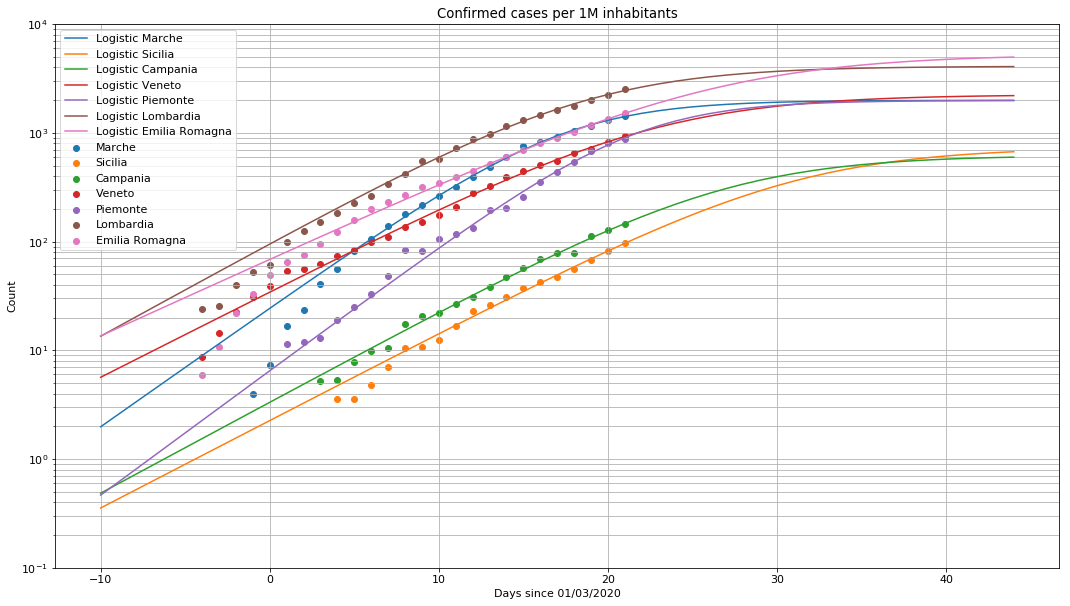

In [35]:
t_fit = list(range(-10, +45))

show_exp = False

for r in pop:
  # Real data
  t = list(regdf[r].iloc[:, 0])
  y = list(regdf[r].iloc[:, 1])
  plt.scatter(t, y, label=r)

  # Predicted logistic curve
  if not show_exp and logit_fit[r]:
    plt.plot(t_fit, [logistic_model(i, logit_fit[r][0][0],logit_fit[r][0][1],logit_fit[r][0][2]) for i in t_fit],
             label=("Logistic %s" % r))

  # Predicted exponential curve
  if show_exp and exp_fit[r]:
    plt.plot(t_fit, [exp_model(i, exp_fit[r][0][0],exp_fit[r][0][1],exp_fit[r][0][2]) for i in t_fit],
             label=("Exponential %s" % r))

plt.legend()
plt.title("Confirmed cases per 1M inhabitants")
plt.xlabel("Days since 01/03/2020")
plt.ylabel("Count")
plt.ylim((0.1, 1e4))
plt.yscale('log')
plt.grid(which='both')
plt.show()